# Programming with RDDs

#### Links

* https://spark.apache.org/docs/1.6.0/programming-guide.html#resilient-distributed-datasets-rdds
* https://spark.apache.org/docs/1.1.1/api/python/pyspark.rdd.RDD-class.html

In [557]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

import os
import sys
import glob
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append('./')

from utils import *


os.environ["PYSPARK_PYTHON"] = "/usr/local/bin/python3.5"

In [558]:
!spark-submit --version

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 1.6.0
      /_/
                        
Type --help for more information.


## Запускаем Spark

In [3]:
import pyspark
from pyspark.conf import SparkConf
from pyspark.sql import SQLContext

conf = SparkConf()
conf.setMaster("yarn-client")
# conf.setMaster("local[*]")
conf.setAppName("spark_examples")
conf.set("spark.executor.memory", "2g")
conf.set("spark.core.connection.ack.wait.timeout", "1200")

conf.set("spark.executor.instances", "2")  # кол-во  executor'ов
conf.set("spark.executor.cores", "2")  # сколько ядер у каждого

sc = pyspark.SparkContext(conf = conf)
sc.addPyFile('./utils.py')
sqlContext = SQLContext(sc)

## Работа с hdfs

Утилитой командной строки -- `hdfs` (https://hadoop.apache.org/docs/current/hadoop-project-dist/hadoop-common/FileSystemShell.html)

Полезные команды:
* `hdfs dfs -ls [<path>]`
* `hdfs dfs -rm <path>`
* `hdfs dfs -mv <src> <dst>`
* `hdfs dfs -copyToLocal <src> <dst local>`
* `hdfs dfs -copyFromLocal <src local> <dst>`


### Копирование данных

Прежде чем начать работать с самим данными их нужно сохранить в hdfs.

1. Запустите terminal через Jupyter
2. `hdfs dfs -copyFromLocal data .`


Проверяем, что все данные на месте

In [559]:
!hdfs dfs -copyFromLocal data .

copyFromLocal: `data/.DS_Store': File exists
copyFromLocal: `data/ml-25m/README.txt': File exists
copyFromLocal: `data/ml-25m/genome-scores.csv': File exists
copyFromLocal: `data/ml-25m/genome-tags.csv': File exists
copyFromLocal: `data/ml-25m/links.csv': File exists
copyFromLocal: `data/ml-25m/ml-25m-README.htm': File exists
copyFromLocal: `data/ml-25m/movies.csv': File exists
copyFromLocal: `data/ml-25m/ratings.csv': File exists
copyFromLocal: `data/ml-25m/tags.csv': File exists
copyFromLocal: `data/ml-25m/tmdb.json': File exists


In [560]:
!hdfs dfs -ls data/ml-25m/

Found 9 items
-rw-r--r--   1 root supergroup      10460 2021-02-16 01:22 data/ml-25m/README.txt
-rw-r--r--   1 root supergroup  435164157 2021-02-16 01:22 data/ml-25m/genome-scores.csv
-rw-r--r--   1 root supergroup      18103 2021-02-16 01:22 data/ml-25m/genome-tags.csv
-rw-r--r--   1 root supergroup    1368578 2021-02-16 01:22 data/ml-25m/links.csv
-rw-r--r--   1 root supergroup      12022 2021-02-16 01:22 data/ml-25m/ml-25m-README.htm
-rw-r--r--   1 root supergroup    3038099 2021-02-16 01:22 data/ml-25m/movies.csv
-rw-r--r--   1 root supergroup  678260987 2021-02-16 01:22 data/ml-25m/ratings.csv
-rw-r--r--   1 root supergroup   38810332 2021-02-16 01:22 data/ml-25m/tags.csv
-rw-r--r--   1 root supergroup  404281742 2021-02-16 01:22 data/ml-25m/tmdb.json


### Чтение данных

*Замечание*: Файл `ml-25m-README.htm` содержит описание данных

In [561]:
DATA_PATH = 'data/ml-25m'

RATINGS_PATH = os.path.join(DATA_PATH, 'ratings.csv')
MOVIES_PATH = os.path.join(DATA_PATH, 'movies.csv')
TAGS_PATH = os.path.join(DATA_PATH, 'tags.csv')

In [562]:
ratings = sc.textFile(RATINGS_PATH)

In [563]:
%%time
ratings.take(5)

CPU times: user 10.9 ms, sys: 7.78 ms, total: 18.7 ms
Wall time: 652 ms


['userId,movieId,rating,timestamp',
 '1,296,5.0,1147880044',
 '1,306,3.5,1147868817',
 '1,307,5.0,1147868828',
 '1,665,5.0,1147878820']

In [564]:
ratings.getNumPartitions()

5

In [565]:
ratings = ratings \
    .map(lambda s: s.split(',')) \
    .filter(lambda arr: arr[0].isdigit()) \
    .map(lambda arr: Rating(user_id=int(arr[0]), 
                            movie_id=int(arr[1]), 
                            rating=float(arr[2]), 
                            timestamp=int(arr[3])))

In [11]:
ratings.count()

25000095

Количество пользователей

In [12]:
%%time

ratings \
    .map(lambda r: r.user_id)\
    .distinct()\
    .count()

CPU times: user 73.1 ms, sys: 15 ms, total: 88.1 ms
Wall time: 2min 5s


162541

Сохраним датасет в память

In [545]:
ratings = ratings.persist()

In [10]:
%%time

ratings \
    .map(lambda r: r.user_id)\
    .distinct()\
    .count()

CPU times: user 164 ms, sys: 42.8 ms, total: 207 ms
Wall time: 3min 25s


162541

Количество фильмов

In [11]:
%%time

ratings \
    .map(lambda r: r.movie_id)\
    .distinct()\
    .count()

CPU times: user 99.4 ms, sys: 58.7 ms, total: 158 ms
Wall time: 2min 28s


59047

## Упражнения

### Фильмы с наибольшим средним рейтингом

Найти 10 фильмов с наибольшим средним рейтингом. Вывести их названия и средний рейтинг

In [566]:
movies = sc.textFile(MOVIES_PATH)
movies.take(5)

['movieId,title,genres',
 '1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy',
 '2,Jumanji (1995),Adventure|Children|Fantasy',
 '3,Grumpier Old Men (1995),Comedy|Romance',
 '4,Waiting to Exhale (1995),Comedy|Drama|Romance']

In [567]:
movies = movies \
    .map(lambda s: s.split(',')[:2]) \
    .filter(lambda arr: arr[0].isdigit()) \
    .keyBy(lambda arr: int(arr[0]))

movie_avg_rating = ratings \
    .map(lambda r: (r.movie_id, (r.rating, 1))) \
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1])) \
    .mapValues(lambda ratings: ratings[0] / ratings[1])

movie_avg_rating \
    .join(movies) \
    .sortBy(lambda key_value: key_value[1][0], ascending=False)\
    .take(10)

[(180663, (5.0, ['180663', '"Goodbye'])),
 (147966, (5.0, ['147966', "Tarzan's Fight for Life (1958)"])),
 (131628, (5.0, ['131628', 'Loaded (2014)'])),
 (131922, (5.0, ['131922', 'Private Duty Nurses (1971)'])),
 (164787, (5.0, ['164787', 'You Cast A Spell On Me (2015)'])),
 (132321, (5.0, ['132321', 'Black Oak Conspiracy (1977)'])),
 (165221, (5.0, ['165221', 'Elf Bowling the Movie (2007)'])),
 (149268, (5.0, ['149268', 'The Pied Piper (1942)'])),
 (116606, (5.0, ['116606', 'Dark Hearts (2014)'])),
 (198527, (5.0, ['198527', 'Drift (2017)']))]

Сохраните `rdd`, состоящий из строк вида `<movie_id>,<average_rating>` на hdfs в виде текстового файла

In [18]:
movie_avg_rating\
    .repartition(10) \
    .saveAsTextFile(os.path.join(DATA_PATH, 'movie_avg_rating'))

In [19]:
! hdfs dfs -ls data/ml-25m/movie_avg_rating

Found 11 items
-rw-r--r--   1 root supergroup          0 2021-02-15 15:05 data/ml-25m/movie_avg_rating/_SUCCESS
-rw-r--r--   1 root supergroup      58933 2021-02-15 15:05 data/ml-25m/movie_avg_rating/part-00000
-rw-r--r--   1 root supergroup     112355 2021-02-15 15:05 data/ml-25m/movie_avg_rating/part-00001
-rw-r--r--   1 root supergroup     131486 2021-02-15 15:05 data/ml-25m/movie_avg_rating/part-00002
-rw-r--r--   1 root supergroup     114271 2021-02-15 15:05 data/ml-25m/movie_avg_rating/part-00003
-rw-r--r--   1 root supergroup     133754 2021-02-15 15:05 data/ml-25m/movie_avg_rating/part-00004
-rw-r--r--   1 root supergroup     117913 2021-02-15 15:05 data/ml-25m/movie_avg_rating/part-00005
-rw-r--r--   1 root supergroup     142927 2021-02-15 15:05 data/ml-25m/movie_avg_rating/part-00006
-rw-r--r--   1 root supergroup     132210 2021-02-15 15:05 data/ml-25m/movie_avg_rating/part-00007
-rw-r--r--   1 root supergroup     167715 2021-02-15 15:05 data/ml-25m/movie_avg_rating/part-000

### Популярность тэгов

Найти 20 наиболее популярных тэгов

In [9]:
tags = sc.textFile(TAGS_PATH)
tags.take(5)

['userId,movieId,tag,timestamp',
 '3,260,classic,1439472355',
 '3,260,sci-fi,1439472256',
 '4,1732,dark comedy,1573943598',
 '4,1732,great dialogue,1573943604']

In [10]:
tags_count = tags\
    .map(lambda s: (s.split(',')[2], 1))\
    .reduceByKey(lambda a, b: a + b)\
    .collect()

len(tags_count)

73016

In [22]:
tags_count = sorted(tags_count, key=lambda tag_count: tag_count[1], reverse=True)

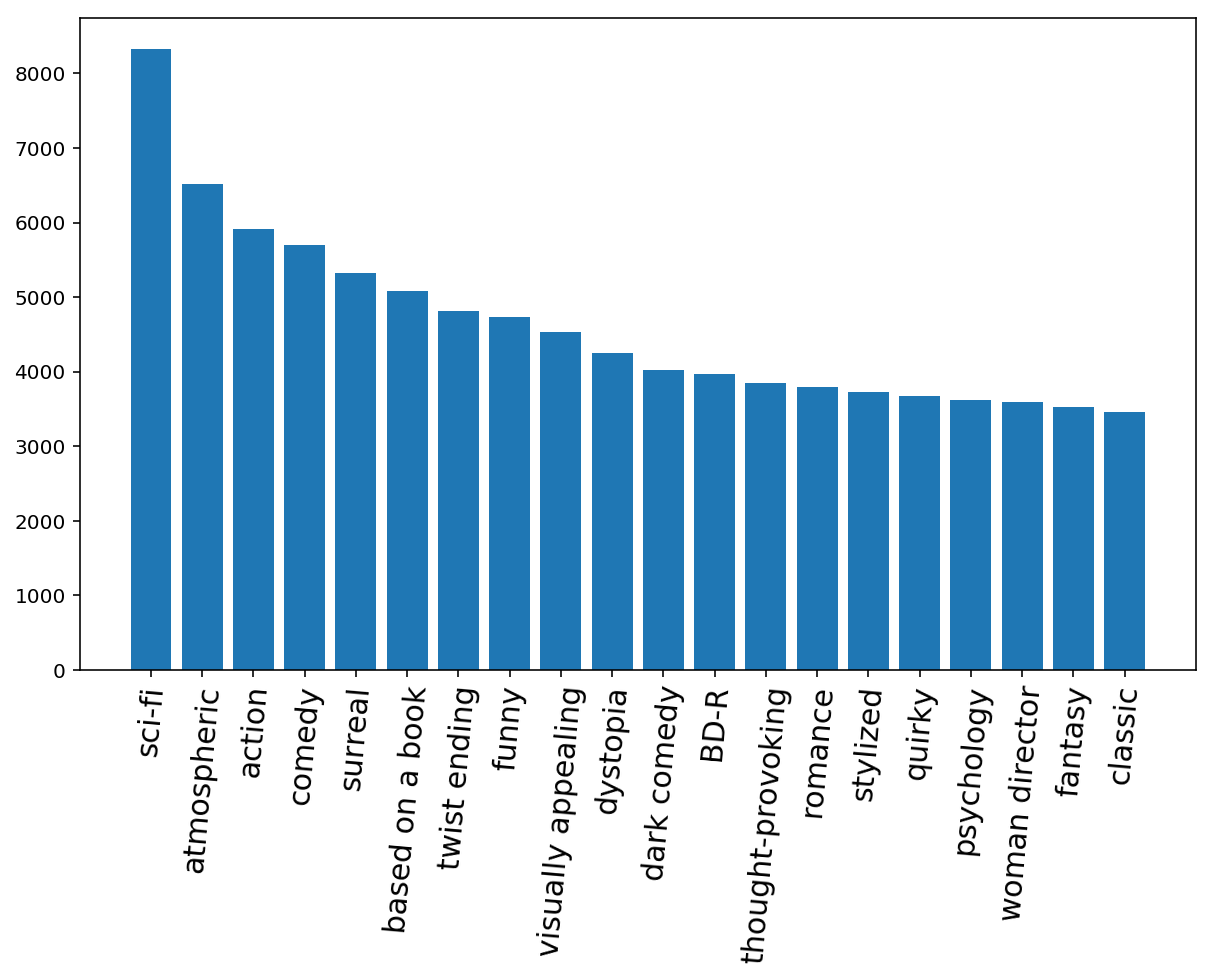

In [23]:
keys, values = zip(*tags_count[:20])

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.bar(keys, values, align="center")
plt.show()

### Фильмы с наибольшим числом оценок

Найти 10 фильмов с наибольшим числом оценок. Вывести их названия и число оценок

In [25]:
ratings \
    .map(lambda r: (r.movie_id, 1)) \
    .reduceByKey(lambda a, b: a + b) \
    .join(movies) \
    .sortBy(lambda key_value: key_value[1], ascending=False) \
    .map(lambda key_value: (key_value[1][1][1], key_value[1][0])) \
    .take(10)

[('Forrest Gump (1994)', 81491),
 ('"Shawshank Redemption', 81482),
 ('Pulp Fiction (1994)', 79672),
 ('"Silence of the Lambs', 74127),
 ('"Matrix', 72674),
 ('Star Wars: Episode IV - A New Hope (1977)', 68717),
 ('Jurassic Park (1993)', 64144),
 ("Schindler's List (1993)", 60411),
 ('Braveheart (1995)', 59184),
 ('Fight Club (1999)', 58773)]

### Фильмы с наибольшим числом 5

Найти 10 фильмов с наибольшим числом 5ок в качестве оценки. Вывести их названия и число 5ок

In [29]:
ratings \
    .map(lambda r: (r.movie_id, int(r.rating == 5.0))) \
    .reduceByKey(lambda a, b: a + b) \
    .join(movies) \
    .sortBy(lambda key_value: key_value[1], ascending=False) \
    .map(lambda key_value: (key_value[1][1][1], key_value[1][0])) \
    .take(10)

[('"Shawshank Redemption', 39553),
 ('Pulp Fiction (1994)', 32169),
 ('Forrest Gump (1994)', 25918),
 ('Star Wars: Episode IV - A New Hope (1977)', 25804),
 ('"Matrix', 25482),
 ("Schindler's List (1993)", 24853),
 ('"Silence of the Lambs', 24801),
 ('"Godfather', 24418),
 ('"Usual Suspects', 21585),
 ('Fight Club (1999)', 21486)]

### Распределение рейтингов фильмов

Построить распределение фильмов по ср. рейтингам  (гистограмму)

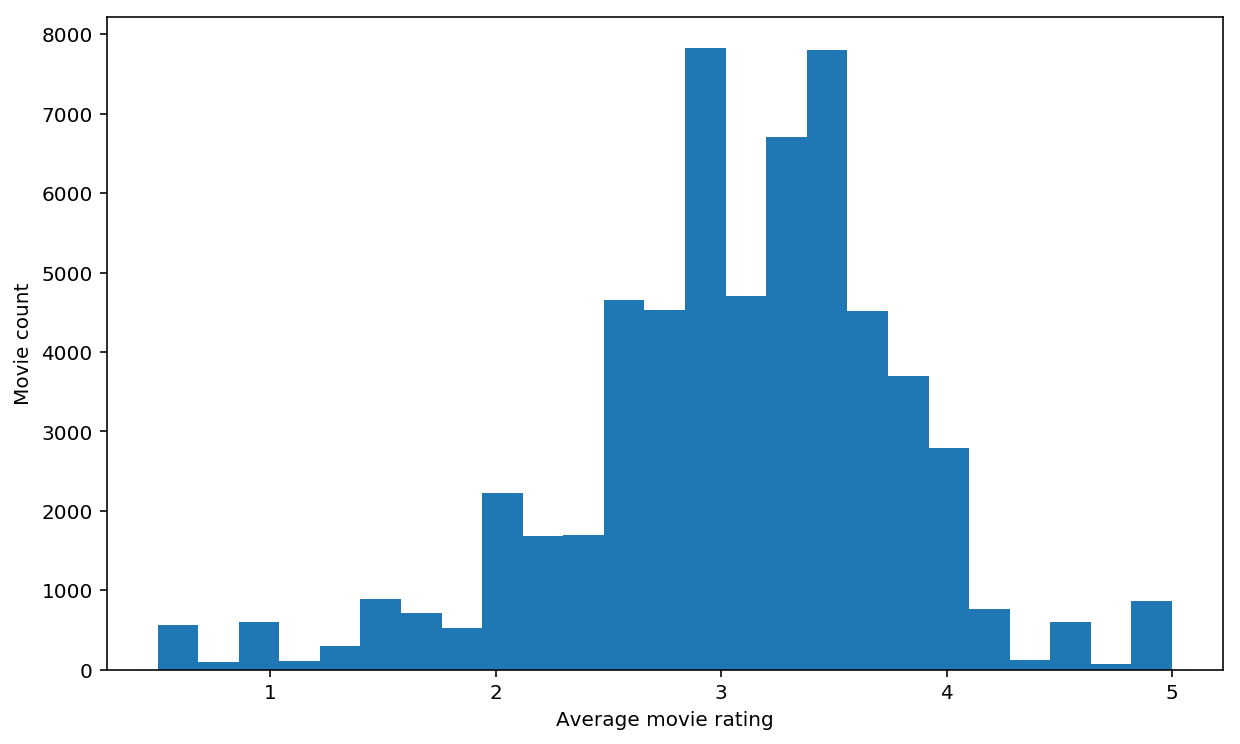

In [570]:
avg_rating_count = movie_avg_rating.map(lambda m: m[1]).collect()
f, ax = plt.subplots(figsize=(10, 6))
plt.xlabel('Average movie rating')
plt.ylabel('Movie count')
plt.hist(avg_rating_count, bins=25)
plt.show()

### Распределение числа оценок для фильмов

Построить распределение фильмов по числу оценок

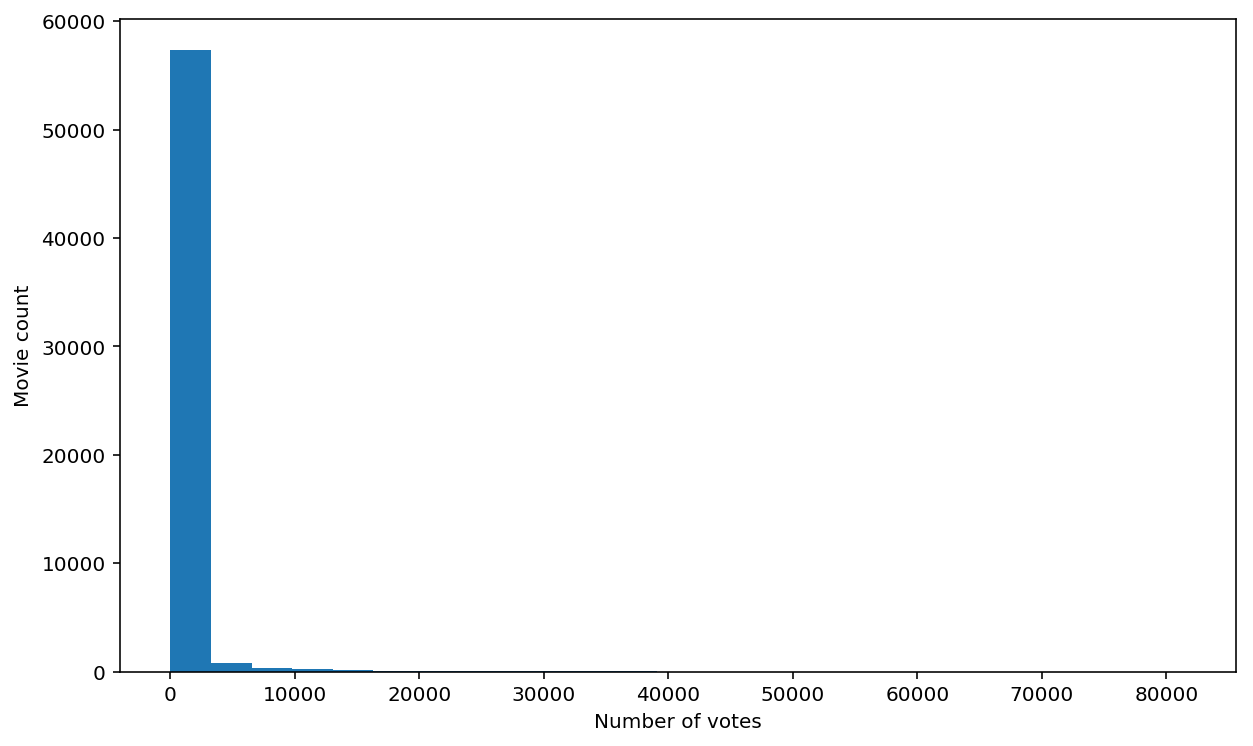

In [571]:
movie_ratings_dist = ratings \
    .map(lambda r: (r.movie_id, 1)) \
    .reduceByKey(lambda a, b: a + b) \
    .map(lambda r: r[1]) \
    .collect()
f, ax = plt.subplots(figsize=(10, 6))
plt.xlabel('Number of votes')
plt.ylabel('Movie count')
plt.hist(movie_ratings_dist, bins=25)
plt.show()

### Распределение фильмов по жанрам

Построить гистограмму распределения фильмов по жанрам. Обратите внимание, что у фильма может быть указано больше одного жанра.

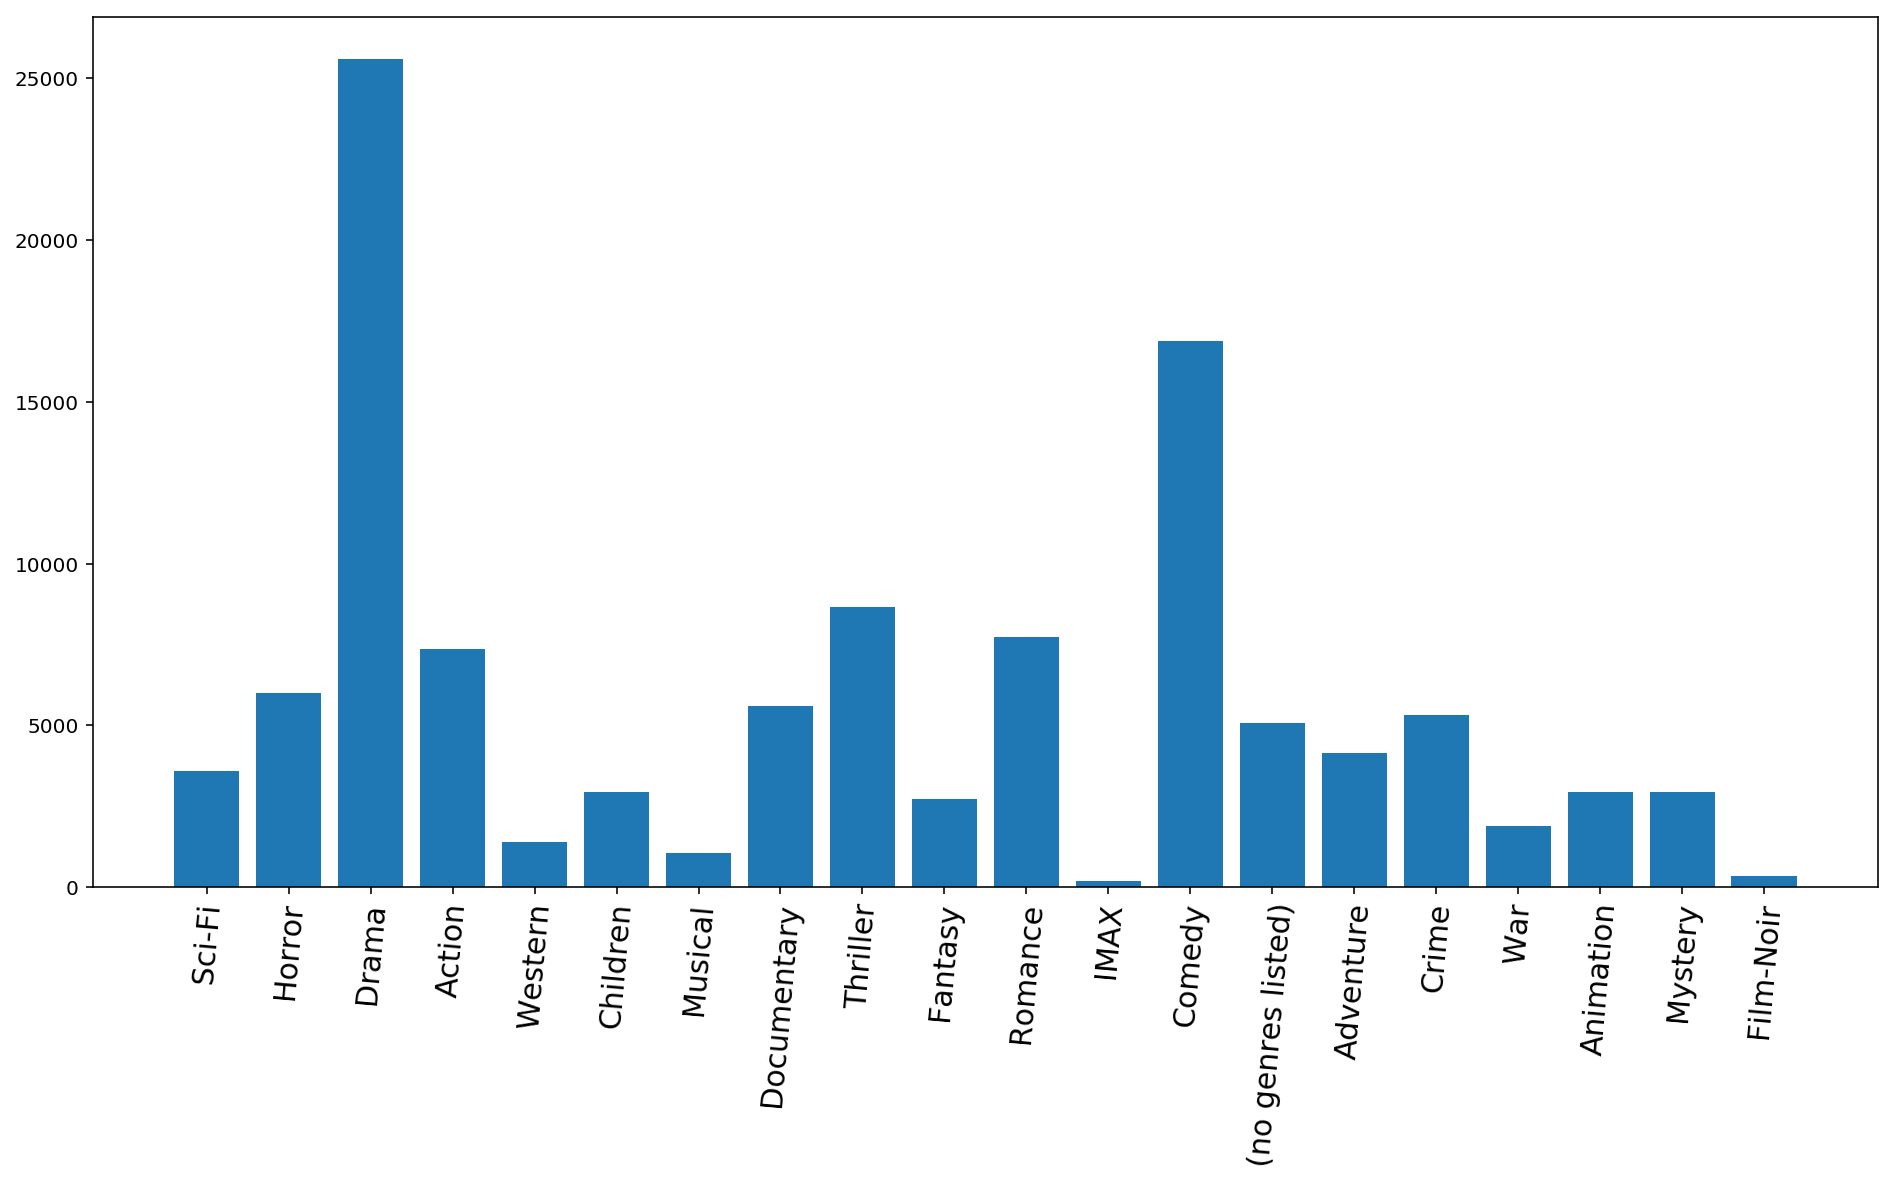

In [25]:
movie_genres = movies \
    .map(lambda s: s.split(",")) \
    .filter(lambda arr: arr[0].isdigit()) \
    .flatMap(lambda s: [genre for genre in s[-1].split("|")]) \
    .map(lambda genre: (genre, 1)) \
    .reduceByKey(lambda a, b: a + b)

keys, values = zip(*movie_genres.collect())
f, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation=85, fontsize=15)
plt.bar(keys, values, align="center")
plt.show()

### Актеры

Для решения задач ниже нужно воспользоваться файлами `ratings.csv`, `movies.csv`, `links.csv` и `tmdb.json`.

* `links.csv` - задает отображение из `movie_id` в `tmdb_movie_id` (подробное описание в `ml-25m-README.htm`)
* `tmdb.json` - содержит большое количество данных о фильмах в формате json (на каждой строчке отдельный json)

Задачи

1. Найти все фильмы, в которых играл `"id":31, "name":"Tom Hanks"`
2. Найти 10 актеров снявшихся в наибольшем числе фильмов. Вывести их имена и кол-во фильмов, в которых они снимались

In [98]:
RATINGS_PATH = os.path.join(DATA_PATH, "ratings.csv")
MOVIES_PATH = os.path.join(DATA_PATH, "movies.csv")
LINKS_PATH = os.path.join(DATA_PATH, "links.csv")
TMDB_PATH = os.path.join(DATA_PATH, "tmdb.json")

ratings = sc.textFile(RATINGS_PATH)
movies = sc.textFile(MOVIES_PATH)
links = sc.textFile(LINKS_PATH)
tmdb = sqlContext.read.json(TMDB_PATH).rdd

In [111]:
links.take(1)

['movieId,imdbId,tmdbId']

In [112]:
links_id = links \
    .map(lambda s: s.split(",")) \
    .filter(lambda arr: arr[0].isdigit()) \
    .map(lambda s: (s[0], s[2])) \
    .keyBy(lambda s: s[1]) \
    .map(lambda s: (s[0], s[1][0]))
links_id.take(1)

[('862', '1')]

In [113]:
movies.take(1)

['movieId,title,genres']

In [114]:
movies_id = movies \
    .map(lambda s: s.split(",")) \
    .filter(lambda s: s[0].isdigit()) \
    .map(lambda s: (s[0], s[1])) \
    .keyBy(lambda s: int(s[0])) 

movies_id.take(1) 

[(1, ('1', 'Toy Story (1995)'))]

In [115]:
tmdb \
    .filter(lambda r: hasattr(r.casts, "cast")) \
    .filter(lambda r: 31 in [actor.id for actor in r.casts.cast]) \
    .map(lambda r: r.id) \
    .keyBy(lambda r: str(r)) \
    .join(links_id) \
    .map(lambda r: r[1][1]) \
    .keyBy(lambda r: int(r)) \
    .join(movies_id) \
    .map(lambda r: r[1][1][1]) \
    .collect()
            

['Sleepless in Seattle (1993)',
 '"Celluloid Closet',
 'Elvis Has Left the Building (2004)',
 '"\'burbs',
 'Splash (1984)',
 'Every Time We Say Goodbye (1986)',
 '"League of Their Own',
 'Captain Phillips (2013)',
 'Toy Story of Terror (2013)',
 'Shooting War (2000)',
 'Killing Lincoln (2013)',
 'Toy Story (1995)',
 'And the Oscar Goes To... (2014)',
 'Bonfire of the Vanities (1990)',
 'Punchline (1988)',
 'Turner & Hooch (1989)',
 'Larry Crowne (2011)',
 'Toy Story Toons: Small Fry (2011)',
 '"Man with One Red Shoe',
 'Toy Story 3 (2010)',
 'Sully (2016)',
 '"Simpsons Movie',
 'Mazes and Monsters (1982)',
 'Magnificent Desolation: Walking on the Moon (2005)',
 'The Post (2017)',
 '"Money Pit',
 "You've Got Mail (1998)",
 'Toy Story 4 (2019)',
 'California Typewriter (2017)',
 'Radio Flyer (1992)',
 'Apollo 13 (1995)',
 'Nothing in Common (1986)',
 'Angels & Demons (2009)',
 '"The Mayo Clinic',
 '"Da Vinci Code',
 "He Knows You're Alone (a.k.a. Blood Wedding) (1980)",
 '"Ladykillers',


In [123]:
tmdb \
    .filter(lambda r: hasattr(r.casts, "cast")) \
    .flatMap(lambda r: [(c.name, 1) for c in r.casts.cast])\
    .reduceByKey(lambda a, b: a + b) \
    .sortBy(lambda r : r[1], ascending=False) \
    .take(10)

[('Bess Flowers', 380),
 ('Frank Welker', 184),
 ('Christopher Lee', 175),
 ('Clarence Nash', 158),
 ('Irving Bacon', 152),
 ('John Carradine', 146),
 ('John Wayne', 142),
 ('Mel Blanc', 140),
 ('Samuel L. Jackson', 134),
 ('Eric Roberts', 133)]

### Доля жанра в течении времени

Для каждого жанра нужно построить как менялась доля вышедших фильмов данного жанра относительно всех остальных жанров.

Дату выхода фильма можно взять из файла `tmdb.json`.

(См. `plt.stackplot`)

In [180]:
unique_geners = tmdb \
    .filter(lambda r: r.genres) \
    .flatMap(lambda r: [r.name for r in r.genres]) \
    .distinct() \
    .collect()

unique_geners

['Science Fiction',
 'Comedy',
 'Mystery',
 'Action',
 'Western',
 'Adventure',
 'Documentary',
 'Romance',
 'Fantasy',
 'Animation',
 'TV Movie',
 'Music',
 'Family',
 'Thriller',
 'Horror',
 'Crime',
 'Drama',
 'History',
 'War']

In [429]:
geners_data = tmdb \
    .filter(lambda r: r.genres)\
    .flatMap(lambda r: [((r.release_date[:4], g.name), 1) for g in r.genres if r.release_date[:4] != '']) \
    .reduceByKey(lambda a, b: a + b) \
    .map(lambda r: (r[0][0], (r[0][1], r[1]))) \
    .groupByKey() \
    .mapValues(list) \
    .sortBy(lambda r: r[0])

In [507]:
import copy 
years = geners_data.count() 

all_years = geners_data \
    .map(lambda r: r[0]) \
    .collect()

geners_by_years = geners_data \
    .map(lambda r: r[1]) \
    .collect()

d = {g: 0 for g in unique_geners} 
gener_rate = [[] for i in range(years)]
data_sum = []
y = [[] for i in range(years)]
for i in range(years):
    gener_rate[i] = copy.deepcopy(d)
    for gener in unique_geners:
        for k in range(len(geners_by_years[i])):
            if geners_by_years[i][k][0] == gener:
                gener_rate[i][gener] = geners_by_years[i][k][1]
    data_sum.append(sum(gener_rate[i].values()))
    for gener in unique_geners:
        y[i].append(gener_rate[i][gener] / data_sum[i])        

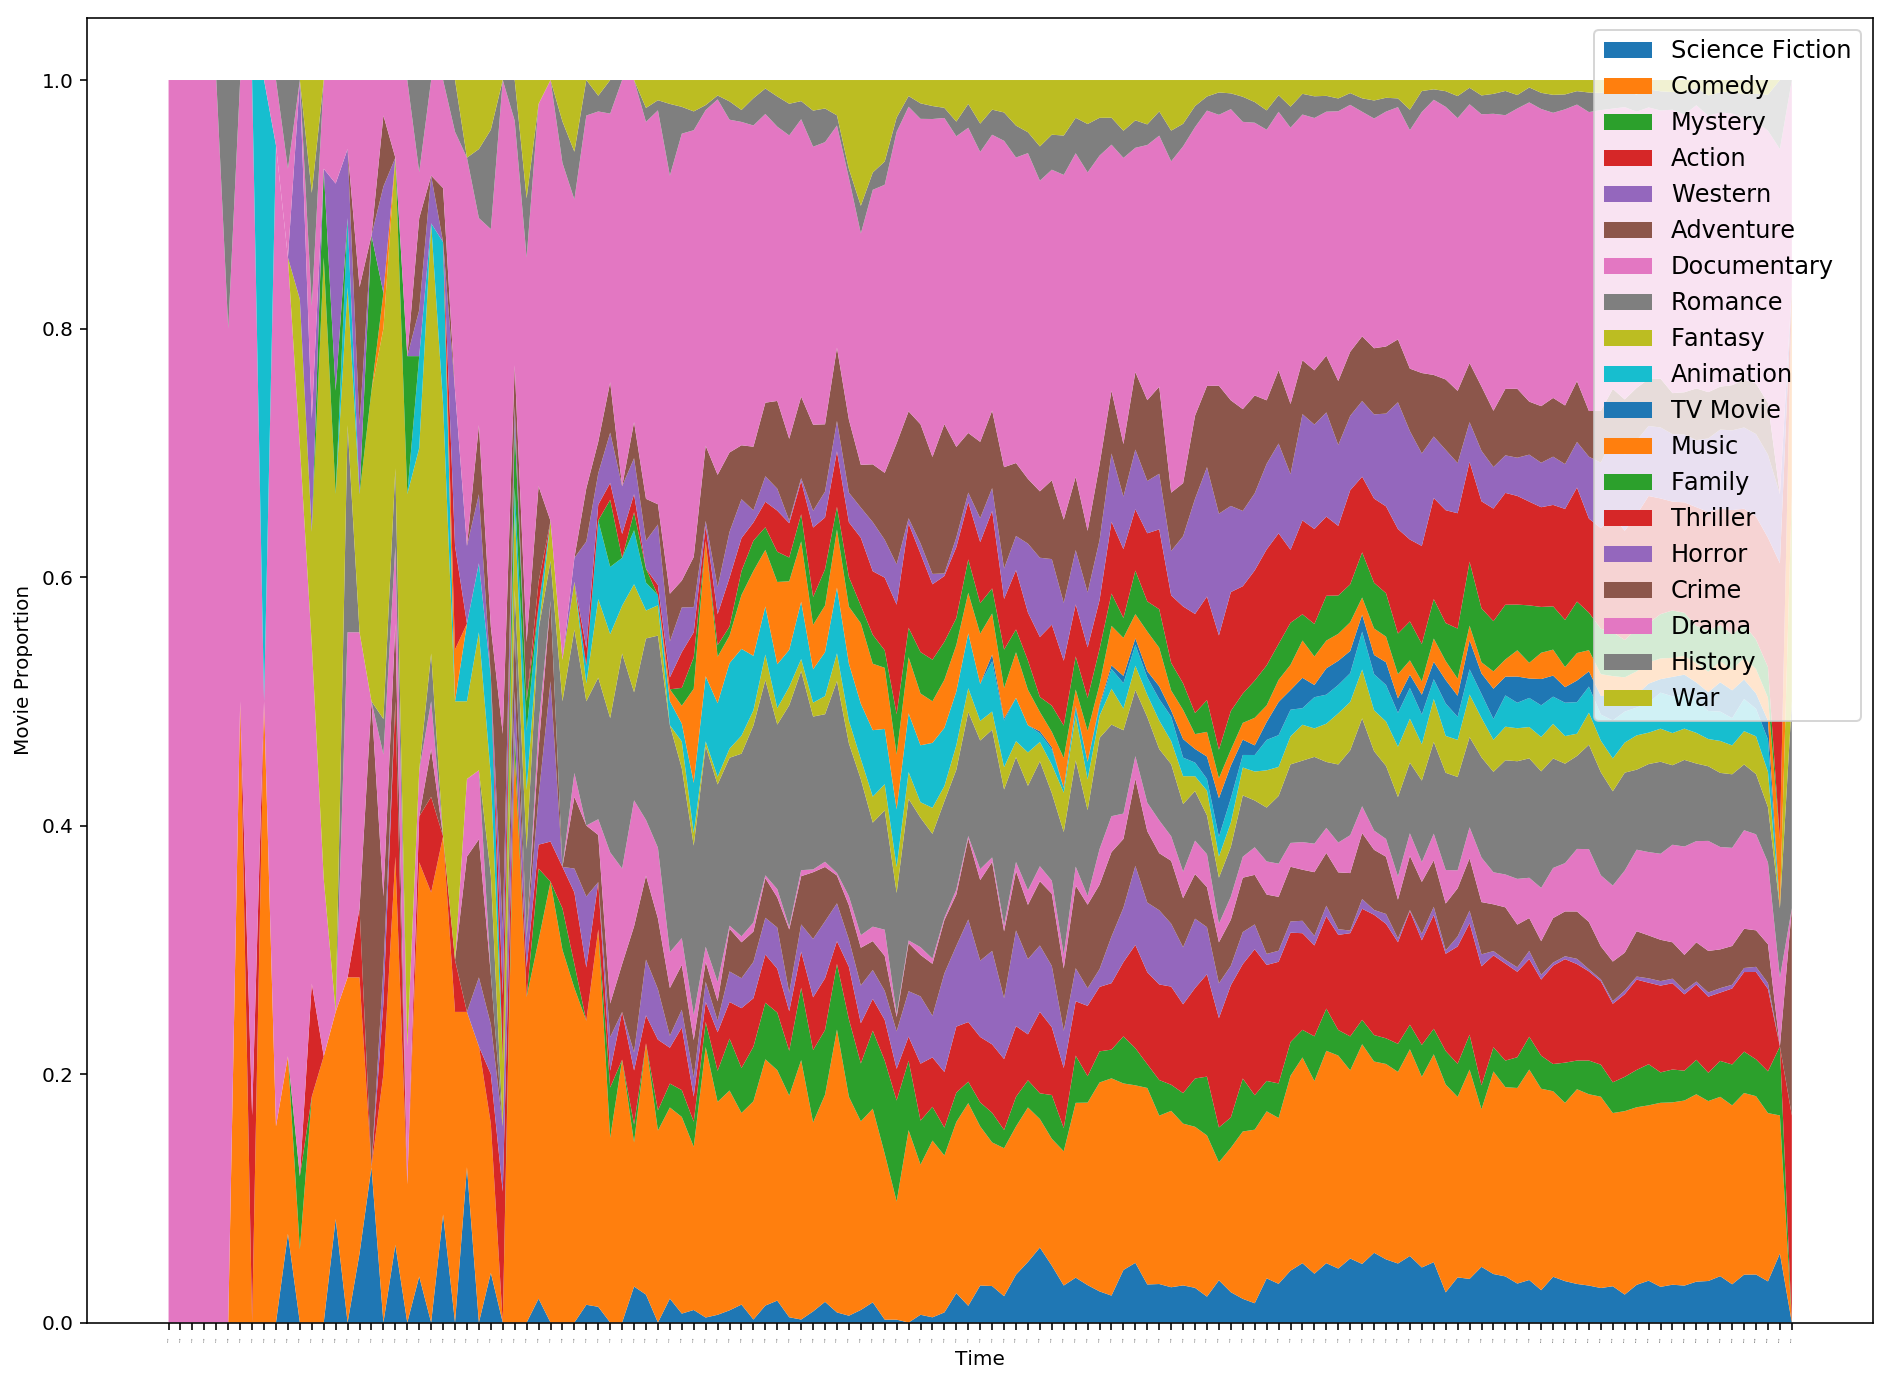

In [539]:
l = np.array(unique_geners)
x = copy.deepcopy(all_years)
f, ax = plt.subplots(figsize=(16, 12))
plt.stackplot(x, np.vstack(y).T, labels=l)
plt.xticks(rotation=85, fontsize=0)
plt.xlabel('Time')
plt.ylabel('Movie Proportion')
plt.legend(fontsize=12)
plt.show()

### Окупаемость фильмов

Для каждого жанра посчитать `ROI = mean(revenue) / mean(budget)` и построить `barplot`, где по оси x будет название жанра, а по оси y - `ROI`

Данные о `revenue` и `budget` можно найти в файле `tmdb.json`.

In [528]:
roi = tmdb \
    .filter(lambda r: r.genres) \
    .flatMap(lambda r : [(g.name, (r.revenue, r.budget)) for g in r.genres]) \
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1])) \
    .mapValues(lambda r: r[0] / r[1]) \
    .sortBy(lambda r: r[1]) \
    .collect()

In [529]:
ROI = np.array(roi)
ROI[1]

array(['Western', '1.6299865996133251'], dtype='<U19')

In [530]:
keys, values = ROI[:, 0], ROI[:, 1].astype(np.float128)

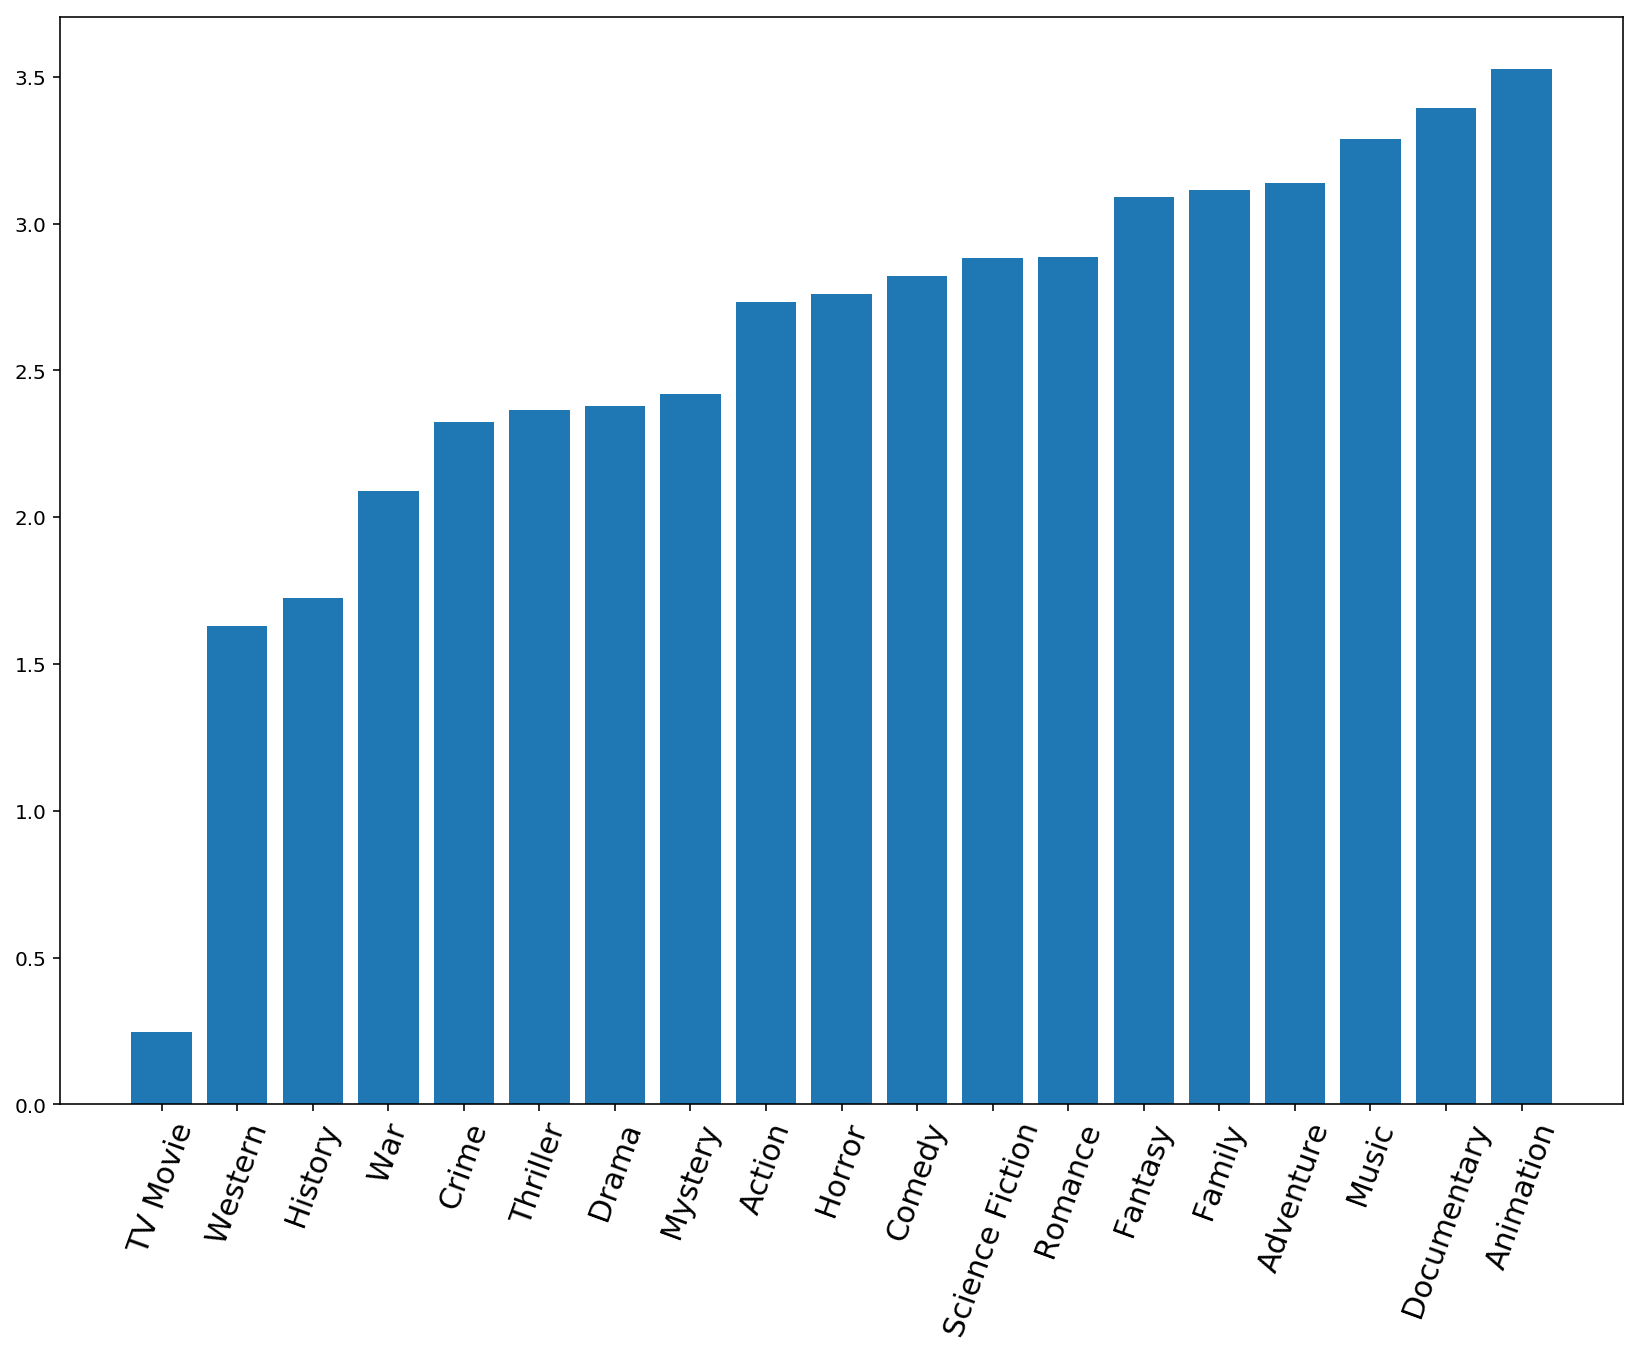

In [540]:
plt.figure(figsize=(14, 10))
plt.xticks(rotation=70, fontsize=15)
plt.bar(keys, values)
plt.show()